# Notes (à enlever à la fin)

The report must include:
- a short introduction of the context and goals
- the whole processing pipeline (including the methods that didn't work!!). Every step should be justified (not only the results but the interpretation is important). Don't forget to comment your code where needed (and to keep it clean)!
- a conclusion/discussion on the results of your pipeline

Timeline
1. Read the images.
2. Check that the images are of sufficient quality and that they do not require preprocessing.
3. Suggest a method for segmenting nematodes.
4. Extract geometric descriptors for each nematode that could reflect its living or dead
status.
5. Confirm by statistical test the effect of the drug.

# Pistes à tester (à enlever à la fin)

- local thresholding
- Split-and-merge


# Introduction

# Imports des librairies

In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter
from skimage.morphology import skeletonize

# Import des images

In [16]:
l_img = []

for filename in os.listdir("Data"):
    img_path = os.path.join("Data", filename)
    img = np.array(Image.open(img_path))
    l_img.append(img)

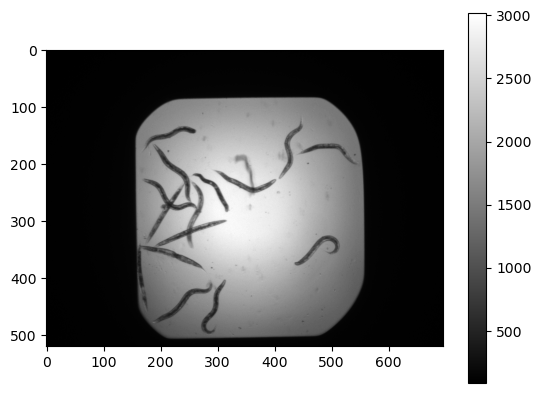

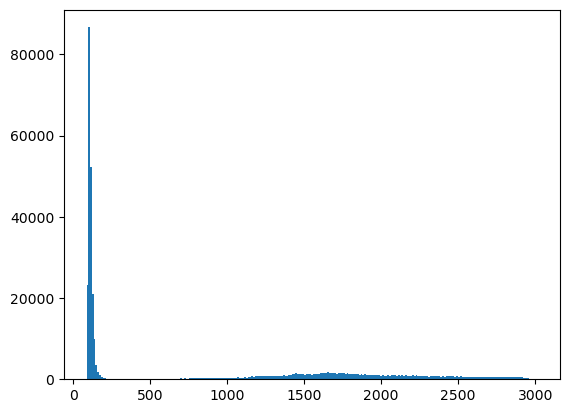

In [17]:
plt.imshow(l_img[0], cmap="gray")
plt.colorbar()
plt.show()

plt.hist(l_img[0].flatten(), bins = 255)
plt.show()

# Preprocessing des images

## Dilatation des histogrammes

In [18]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

In [19]:
l_img_stretched = []

for img in l_img :
    l_img_stretched.append(stretch(img).astype(int).copy())

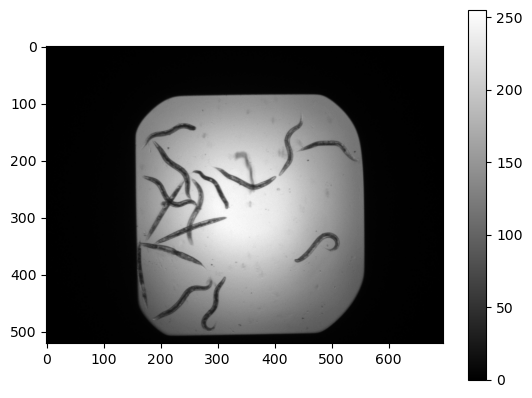

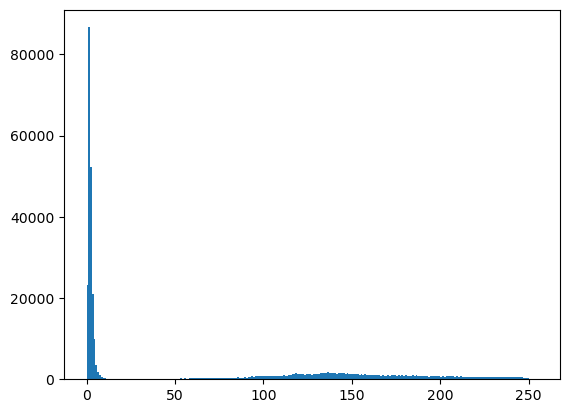

In [20]:
plt.imshow(l_img_stretched[0], cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(l_img_stretched[0].flatten(), bins = 255)
plt.show()

# Seuillage

## Seuil global

## Seuil local

In [74]:
l_img_local_thresholded = []

block_size = 51
for img in l_img_stretched:
    local_thresh = filters.threshold_local(img, block_size, offset=10)
    l_img_local_thresholded.append(img < local_thresh)


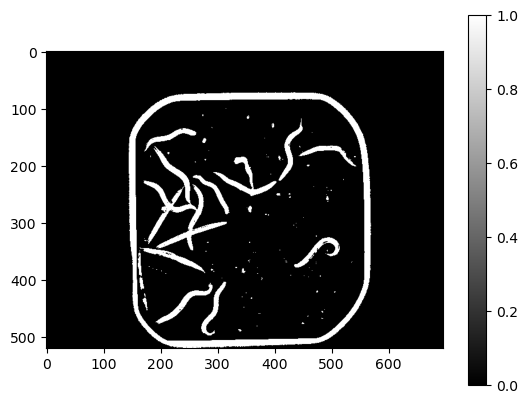

In [75]:
plt.imshow(l_img_local_thresholded[0], cmap="gray")
plt.colorbar()
plt.show()

# Supression du contour du récipiant

In [76]:
l_window = []

window_threshold = 8

for img in l_img_stretched:
    window = img>window_threshold
    l_window.append(window)

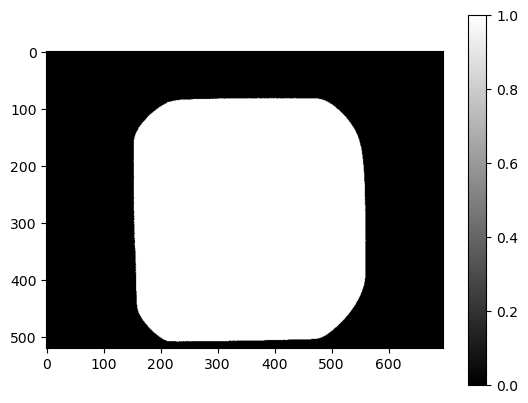

In [77]:
plt.imshow(l_window[0], cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [78]:
l_window_countour = []

for window in  l_window :
    l_window_countour.append(stretch(filters.sobel(window))>30)


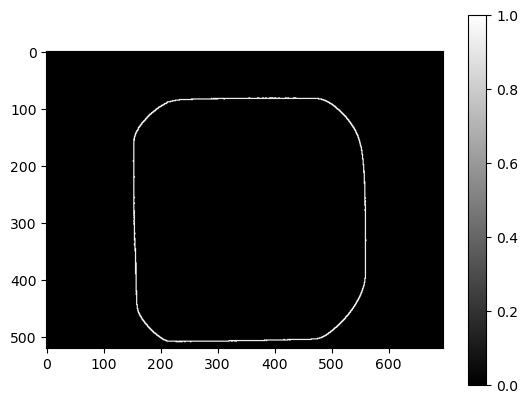

In [79]:
plt.imshow(l_window_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [92]:
l_wide_window_negative_countour = []

width = 19

for negative_countour in l_window_countour:
    l_wide_window_negative_countour.append(signal.convolve2d(negative_countour,np.ones((width,width)),mode='same')==0)


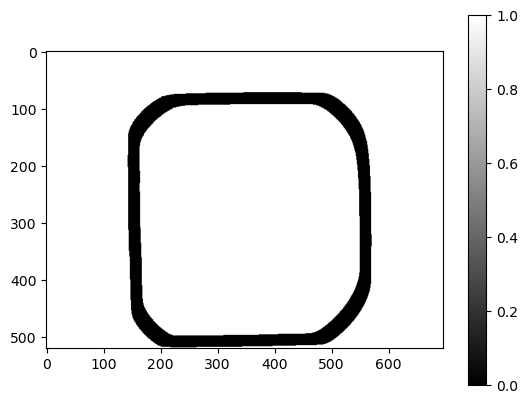

In [93]:
plt.imshow(l_wide_window_negative_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [94]:
l_img_local_thresholded_nematods = []

for i,img in enumerate(l_img_local_thresholded):
    l_img_local_thresholded_nematods.append(np.multiply(img, l_wide_window_negative_countour[i]))

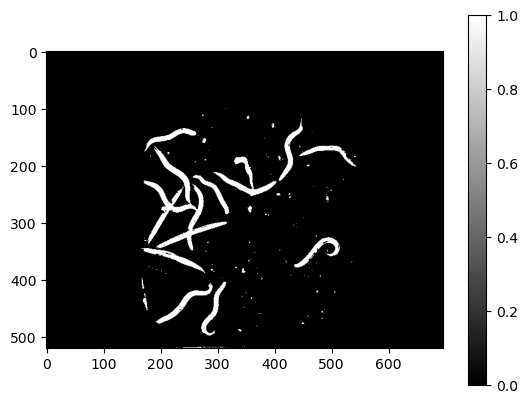

In [95]:
plt.imshow(l_img_local_thresholded_nematods[0], cmap="gray")
plt.colorbar()
plt.show()

# Opérations Morphologiques

In [96]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [97]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    dil_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                dil_img[i,j] = 1
            else :
                dil_img[i,j] = 0
    return dil_img


In [98]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

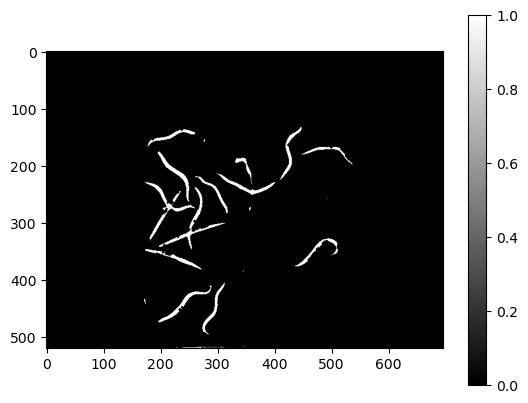

In [103]:
test = multiple_erosions_and_dilataions(l_img_local_thresholded_nematods[0],2*['e'])
plt.imshow(test, cmap="gray")
plt.colorbar()
plt.show()

# Squelettisation 

In [104]:
l_skeleton = []

for img in l_img_local_thresholded_nematods:
    l_skeleton.append(skeletonize(img))

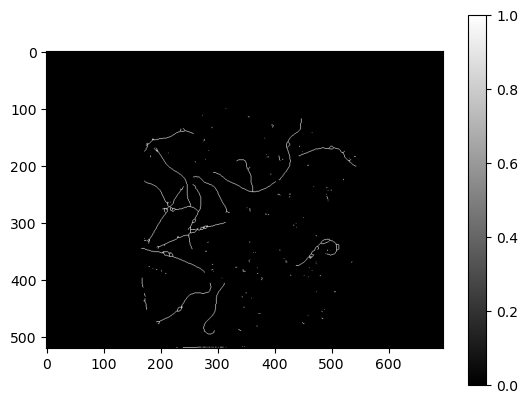

In [105]:
plt.imshow(l_skeleton[0], cmap="gray")
plt.colorbar()
plt.show()

# Labélisation des nématodes

# Calcul des caractéristiques géométriques

# Analyse des résultats

# Conclusion